In [1]:
import numpy as np
import scipy
from scipy.optimize import minimize

In [2]:
N = 15
M = 10
xx =  np.linspace(-1,1,M)

In [3]:
def theory(A,B):
    return A[:,None]+np.outer(B,xx)

def theory_simple(A):
    return np.outer(A,np.ones(M))

def get_noise (noise_sigma):
    return np.random.normal(0,noise_sigma,(N,M))

def chi2_full(data,A,B, noise_sigma):
    return ((data-theory(A,B))**2/noise_sigma**2).sum()

def chi2_simple(data,A, noise_sigma):
    return ((data-theory_simple(A))**2/noise_sigma**2).sum()

def regularized_like (data,A,B,log_var_reg, noise_sigma):
    baselike = chi2_full(data,A,B,noise_sigma)/2
    var_reg=np.exp(log_var_reg)
    reg_like = (B**2/var_reg).sum()/2 + 1/2*np.log(var_reg)*N
    return baselike+reg_like


In [4]:
#true values
Atrue = np.random.uniform(0,2,N)
Btrue = np.random.normal(0,0.01,N)
data_true = theory(Atrue,Btrue)
noise_realization=get_noise(1.0)
print ((noise_realization**2).sum(),N*M)

167.27482144393 150


(0.0, 300.0)

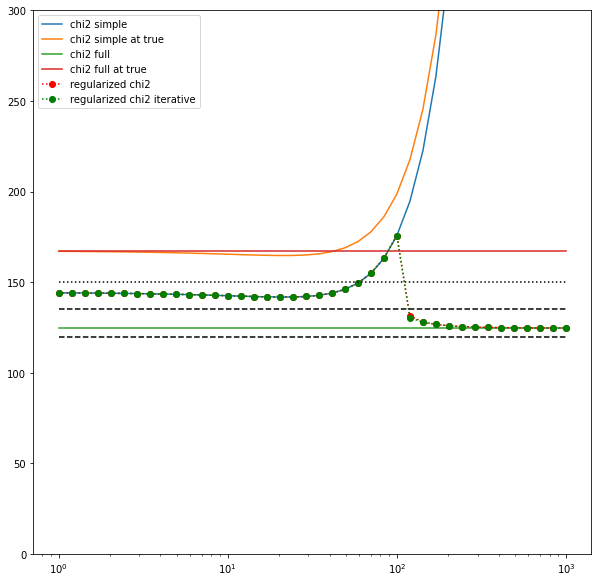

In [5]:
toplot=[]
for snr in np.logspace(0.,3.,40):

    noise = 1/snr
    data = data_true+noise_realization*noise
    chi2 = minimize (lambda A: chi2_simple(data,A,noise),Atrue,method='powell')
    
    chi2_true = chi2_simple(data,Atrue,noise)
    fchi2 = minimize (lambda X: chi2_full(data,X[:N],X[N:],noise),np.hstack((Atrue,Btrue)),method='powell')
    fchi2_true = chi2_full(data,Atrue,Btrue,noise)
    
    rchi2 = minimize (lambda X: 2*regularized_like(data,X[:N],X[N:-1],X[-1],noise), np.hstack((Atrue,Btrue,-1)), method='powell')
    sigr = np.exp(rchi2.x[-1])
    rchi2 = chi2_full(data,rchi2.x[:N],rchi2.x[N:-1],noise)
    
    ## iterative regularization
    Ac, Bc, logreg = Atrue, Btrue, -1
    last_like = 1e150
    while True:
        t = minimize (lambda X: 2*regularized_like(data,X[:N],X[N:],logreg,noise), np.hstack((Ac,Bc)), method='powell')
        Ac,Bc = t.x[:N], t.x[N:]
        logreg = np.log((Bc**2).mean())
        if last_like-t.fun<0.1:
            break
        last_like = t.fun
    rchi2it = chi2_full(data,Ac,Bc,noise)
    sigrit = np.exp(logreg)
    toplot.append([snr, chi2.fun, chi2_true, fchi2.fun, fchi2_true, rchi2, sigr,rchi2it, sigrit])
    
toplot=np.array(toplot)
plt.figure(figsize=(10,10))
plt.plot(toplot[:,0],toplot[:,1],label='chi2 simple ')
plt.plot(toplot[:,0],toplot[:,2],label='chi2 simple at true')
plt.plot(toplot[:,0],toplot[:,3],label='chi2 full')
plt.plot(toplot[:,0],toplot[:,4],label='chi2 full at true')
plt.plot(toplot[:,0],toplot[:,5],'ro:',label='regularized chi2')
plt.plot(toplot[:,0],toplot[:,7],'go:',label='regularized chi2 iterative')
plt.plot(toplot[(0,-1),0],[N*M,N*M],'k:')
plt.plot(toplot[(0,-1),0],[N*M-N,N*M-N],'k--')
plt.plot(toplot[(0,-1),0],[N*M-2*N,N*M-2*N],'k--')
plt.semilogx()
plt.legend()
plt.ylim(0,N*M*2)

[]

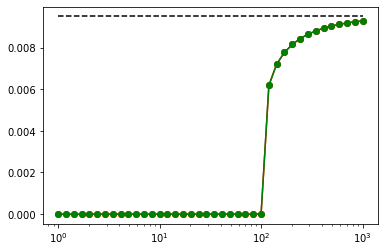

In [6]:
sigmaxlike = np.sqrt((Btrue**2).mean())
plt.plot(toplot[:,0],np.sqrt(toplot[:,6]),'ro-',label='sigma')
plt.plot(toplot[:,0],np.sqrt(toplot[:,6]),'go-',label='sigmait')
plt.plot(toplot[[0,-1],0],[sigmaxlike,sigmaxlike],'k--',label='sigma')
plt.semilogx()